## analyze LLM evaluations (human-human baseline)

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [2]:
# Load the evaluation results
evaluation_file = "evaluations/evaluations_pairwise_human-human_20251030_155122.json"

with open(evaluation_file, 'r') as f:
    data = json.load(f)

print(f"Loaded {data['metadata']['total_evaluations']} evaluations")
print(f"Evaluation type: {data['metadata']['evaluation_type']}")

# Get all evaluations
evaluations = data['evaluations']
print(f"\nNumber of evaluations: {len(evaluations)}")


Loaded 110 evaluations
Evaluation type: pairwise_human-human

Number of evaluations: 110


In [3]:
# Extract unique proposal IDs and create mapping
proposal_ids = set()
for eval_data in evaluations:
    proposal_ids.add(eval_data['proposal_1_id'])
    proposal_ids.add(eval_data['proposal_2_id'])

# Sort proposal IDs for consistent ordering
proposal_ids = sorted(list(proposal_ids))
n_proposals = len(proposal_ids)

print(f"Number of unique proposals: {n_proposals}")
print(f"Proposal IDs: {proposal_ids}")

# Create index mapping
id_to_idx = {pid: idx for idx, pid in enumerate(proposal_ids)}
print(f"\nID to index mapping created")


Number of unique proposals: 11
Proposal IDs: ['human_1', 'human_10', 'human_11', 'human_12', 'human_2', 'human_3', 'human_4', 'human_5', 'human_6', 'human_7', 'human_9']

ID to index mapping created


In [4]:
# Extract dimension names
dimension_names = []
if evaluations and 'evaluation_response' in evaluations[0]:
    comparison = evaluations[0]['evaluation_response'].get('comparison', {})
    dimensions = comparison.get('dimensions', [])
    dimension_names = [d['dimension'] for d in dimensions]

print(f"Dimensions found: {dimension_names}")

# Initialize matrices for each dimension
matrices = {}
for dim_name in dimension_names:
    # Initialize with NaN
    matrices[dim_name] = np.full((n_proposals, n_proposals), np.nan)

print(f"\nInitialized {len(matrices)} matrices, each of size {n_proposals}x{n_proposals}")


Dimensions found: ['Research Question / Aims', 'Data / Empirical Context', 'Methods / Design', 'Intended Contribution / Outcomes', 'Resources / Timing / Artifacts']

Initialized 5 matrices, each of size 11x11


In [ ]:
# Fill matrices with scores from evaluations
for eval_data in evaluations:
    prop_1_id = eval_data['proposal_1_id']
    prop_2_id = eval_data['proposal_2_id']
    
    # Get indices
    idx_1 = id_to_idx[prop_1_id]
    idx_2 = id_to_idx[prop_2_id]
    
    # Extract scores for each dimension
    if 'evaluation_response' in eval_data:
        comparison = eval_data['evaluation_response'].get('comparison', {})
        dimensions = comparison.get('dimensions', [])
        
        for dim in dimensions:
            dim_name = dim['dimension']
            score = dim['score']
            
            # Fill the matrix (asymmetric comparison)
            if dim_name in matrices:
                matrices[dim_name][idx_1, idx_2] = score

print("Matrices filled with evaluation scores!")
print(f"\nExample: Research Question / Aims matrix shape: {matrices[dimension_names[0]].shape}")


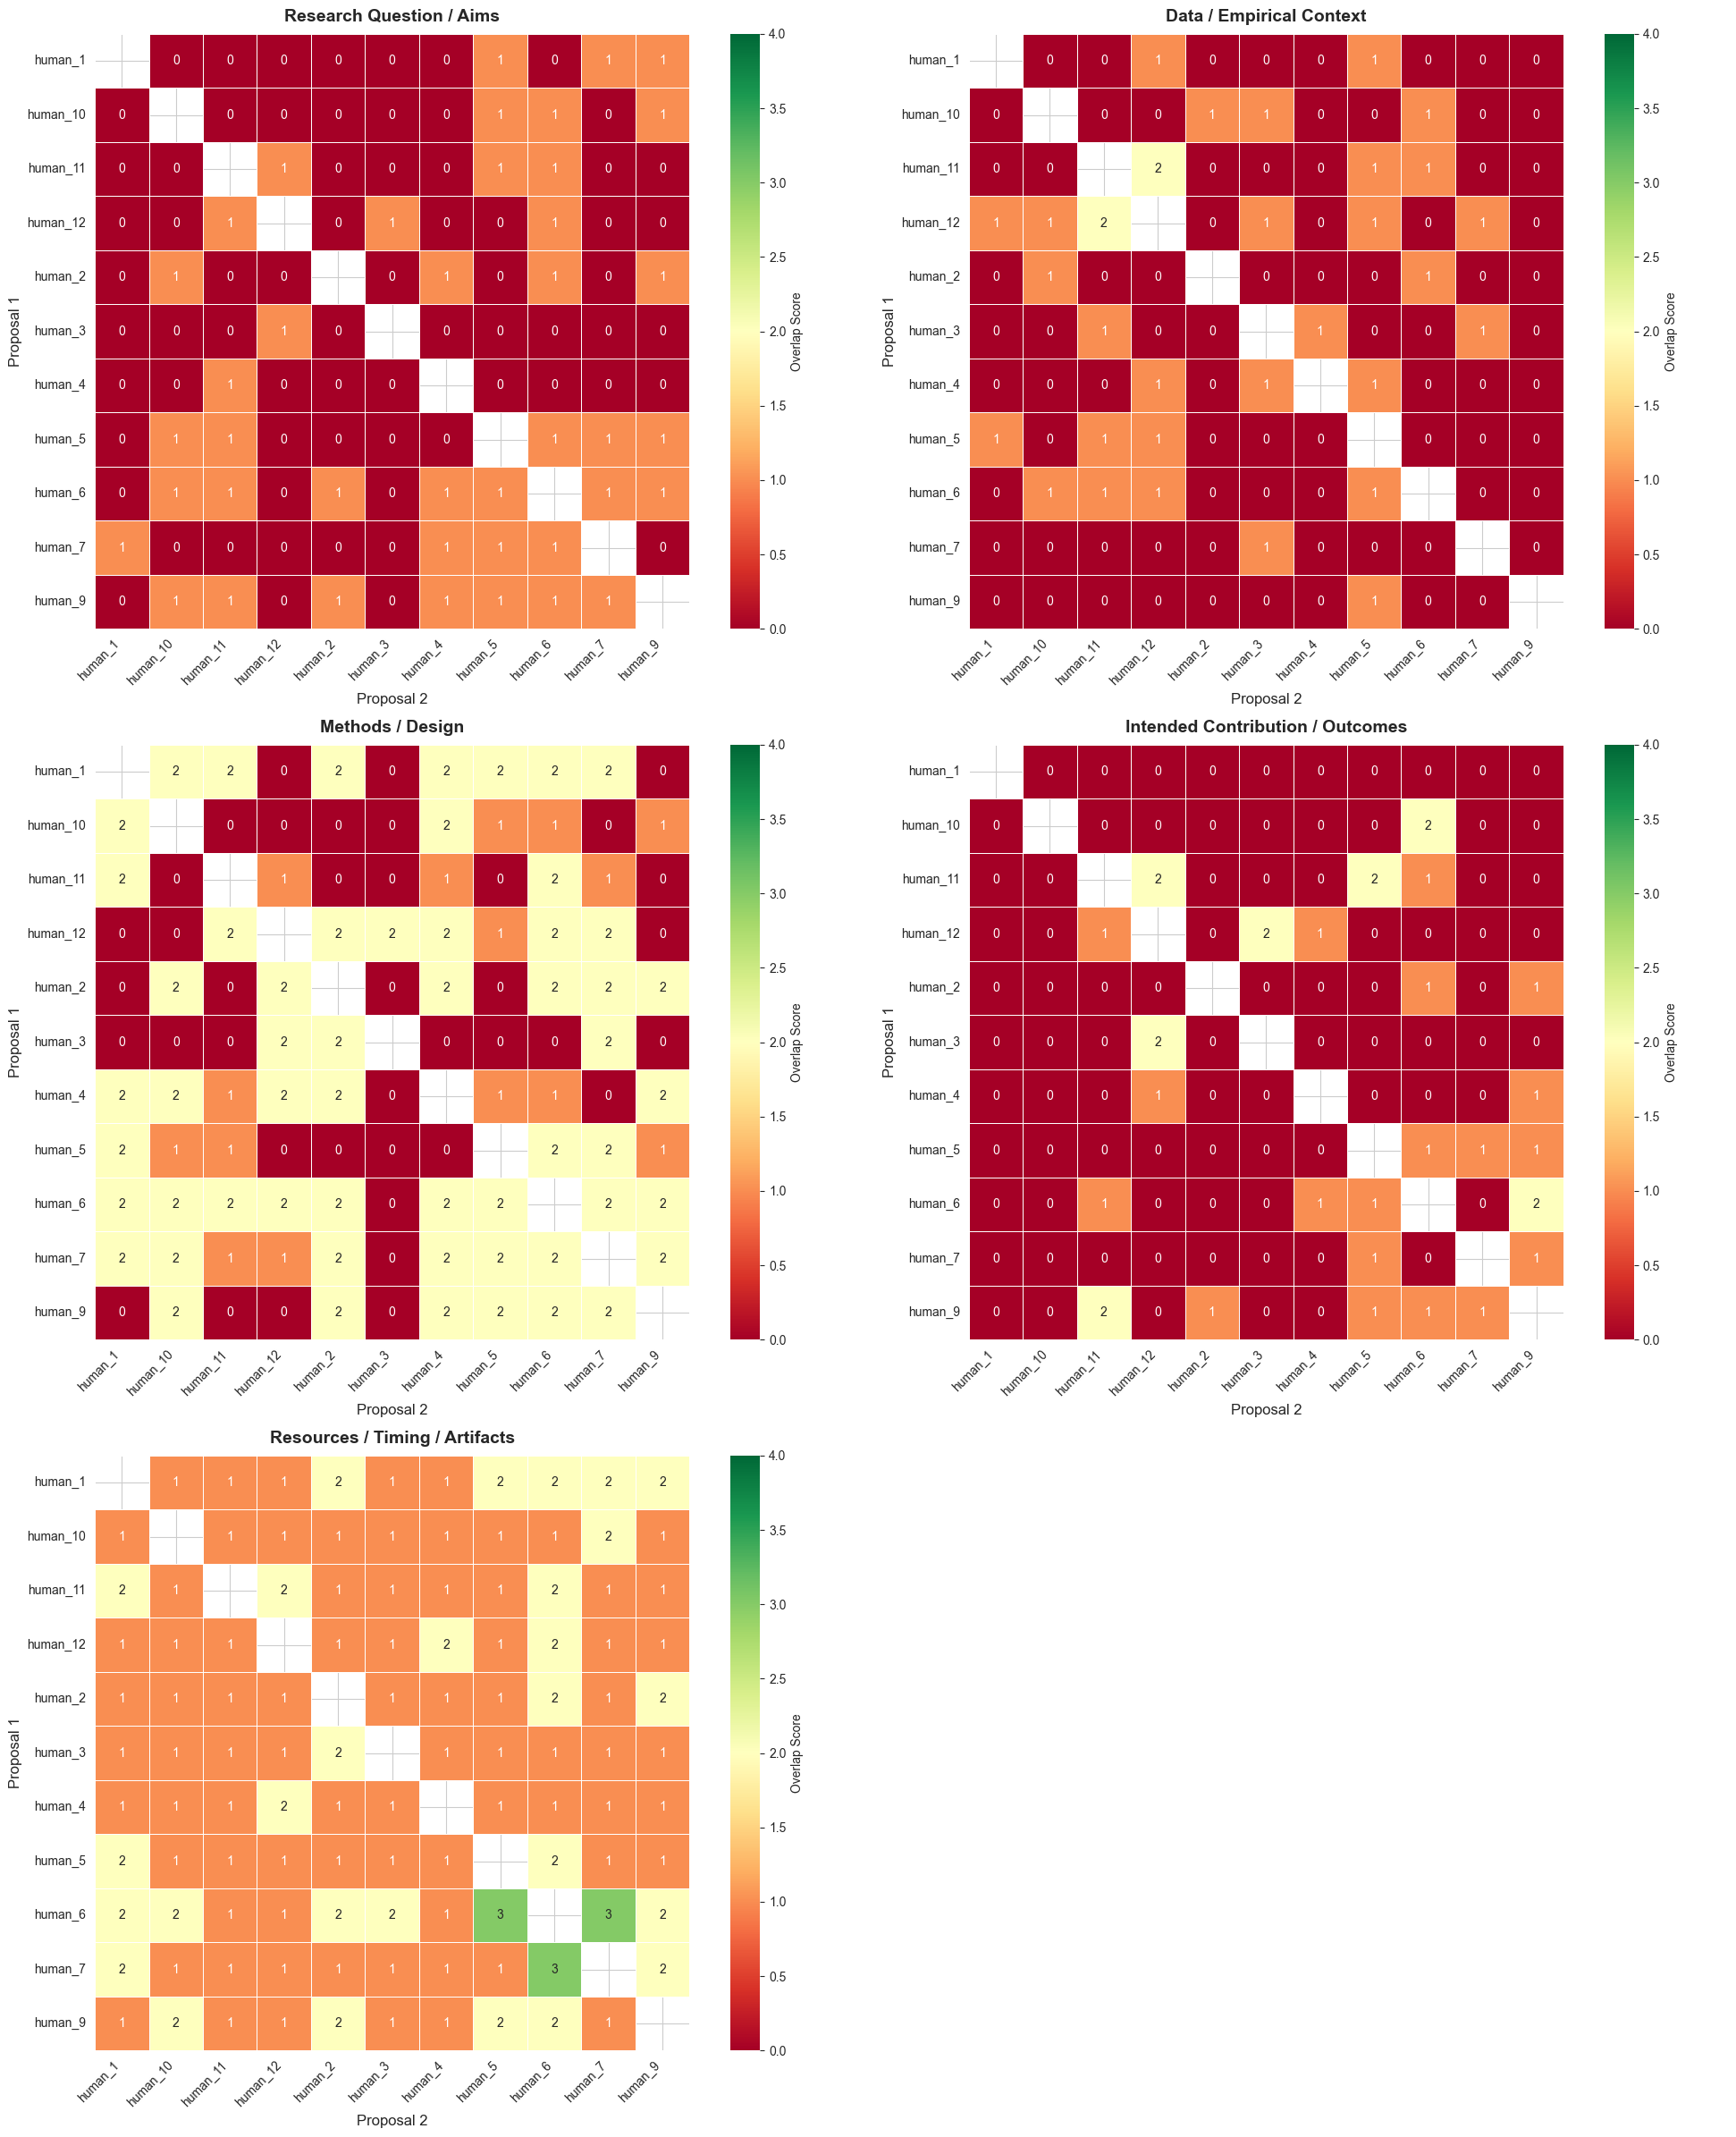

In [6]:
# Create visualizations - one heatmap per dimension
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
axes = axes.flatten()

for idx, dim_name in enumerate(dimension_names):
    ax = axes[idx]
    matrix = matrices[dim_name]
    
    # Create heatmap
    sns.heatmap(matrix, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=4,
                cbar_kws={'label': 'Overlap Score'}, xticklabels=proposal_ids,
                yticklabels=proposal_ids, ax=ax, linewidths=0.5, square=True)
    
    ax.set_title(f'{dim_name}', fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Proposal 2', fontsize=12)
    ax.set_ylabel('Proposal 1', fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

if len(dimension_names) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.savefig('evaluations/overlap_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Create individual plots for each dimension (larger, more detailed)
for dim_name in dimension_names:
    fig, ax = plt.subplots(figsize=(14, 12))
    matrix = matrices[dim_name]
    
    sns.heatmap(matrix, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=4,
                cbar_kws={'label': 'Overlap Score (0-4)'}, xticklabels=proposal_ids,
                yticklabels=proposal_ids, ax=ax, linewidths=1, linecolor='white',
                square=True, annot_kws={'size': 11, 'weight': 'bold'})
    
    ax.set_title(f'{dim_name}\nPairwise Overlap Scores', fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Proposal 2 (Compared Against)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Proposal 1 (Reference)', fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    
    plt.tight_layout()
    safe_name = dim_name.replace('/', '_').replace(' ', '_').lower()
    plt.savefig(f'evaluations/matrix_{safe_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: matrix_{safe_name}.png")


In [7]:
# Summary statistics for each dimension
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)

for dim_name in dimension_names:
    matrix = matrices[dim_name]
    valid_scores = matrix[~np.isnan(matrix)]
    
    print(f"\n{dim_name}:")
    print(f"  Mean score: {np.mean(valid_scores):.2f}")
    print(f"  Median score: {np.median(valid_scores):.2f}")
    print(f"  Std dev: {np.std(valid_scores):.2f}")
    print(f"  Min: {np.min(valid_scores):.0f}, Max: {np.max(valid_scores):.0f}")
    print(f"  Score distribution:")
    for score in range(5):
        count = np.sum(valid_scores == score)
        pct = count / len(valid_scores) * 100
        print(f"    Score {score}: {count:3d} ({pct:5.1f}%)")


SUMMARY STATISTICS

Research Question / Aims:
  Mean score: 0.37
  Median score: 0.00
  Std dev: 0.48
  Min: 0, Max: 1
  Score distribution:
    Score 0:  69 ( 62.7%)
    Score 1:  41 ( 37.3%)
    Score 2:   0 (  0.0%)
    Score 3:   0 (  0.0%)
    Score 4:   0 (  0.0%)

Data / Empirical Context:
  Mean score: 0.30
  Median score: 0.00
  Std dev: 0.50
  Min: 0, Max: 2
  Score distribution:
    Score 0:  79 ( 71.8%)
    Score 1:  29 ( 26.4%)
    Score 2:   2 (  1.8%)
    Score 3:   0 (  0.0%)
    Score 4:   0 (  0.0%)

Methods / Design:
  Mean score: 1.15
  Median score: 2.00
  Std dev: 0.92
  Min: 0, Max: 2
  Score distribution:
    Score 0:  39 ( 35.5%)
    Score 1:  15 ( 13.6%)
    Score 2:  56 ( 50.9%)
    Score 3:   0 (  0.0%)
    Score 4:   0 (  0.0%)

Intended Contribution / Outcomes:
  Mean score: 0.30
  Median score: 0.00
  Std dev: 0.58
  Min: 0, Max: 2
  Score distribution:
    Score 0:  84 ( 76.4%)
    Score 1:  19 ( 17.3%)
    Score 2:   7 (  6.4%)
    Score 3:   0 (  0.0%)

In [8]:
# Find high-overlap proposal pairs (score >= 3 in any dimension)
print("\n" + "="*60)
print("HIGH OVERLAP PAIRS (Score >= 3)")
print("="*60)

for dim_name in dimension_names:
    matrix = matrices[dim_name]
    high_overlap_indices = np.argwhere(matrix >= 3)
    
    if len(high_overlap_indices) > 0:
        print(f"\n{dim_name}:")
        for idx1, idx2 in high_overlap_indices:
            prop1 = proposal_ids[idx1]
            prop2 = proposal_ids[idx2]
            score = matrix[idx1, idx2]
            print(f"  {prop1} vs {prop2}: Score = {score:.0f}")
    else:
        print(f"\n{dim_name}: No high overlap pairs found")



HIGH OVERLAP PAIRS (Score >= 3)

Research Question / Aims: No high overlap pairs found

Data / Empirical Context: No high overlap pairs found

Methods / Design: No high overlap pairs found

Intended Contribution / Outcomes: No high overlap pairs found

Resources / Timing / Artifacts:
  human_6 vs human_5: Score = 3
  human_6 vs human_7: Score = 3
  human_7 vs human_6: Score = 3


Matrices filled with evaluation scores!

Example: Research Question / Aims matrix shape: (11, 11)


# Similarity Analysis Visualization

Now let's visualize the similarity scores from the textual similarity analysis.


In [9]:
# Load similarity analysis results
similarity_file = "similarity_analysis/similarity_human-human_20251030_160213.csv"
similarity_df = pd.read_csv(similarity_file)

print(f"Loaded {len(similarity_df)} similarity comparisons")

Loaded 110 similarity comparisons


In [10]:
# Extract unique proposal IDs from similarity data
sim_proposal_ids = set()
for _, row in similarity_df.iterrows():
    sim_proposal_ids.add(row['proposal_1_id'])
    sim_proposal_ids.add(row['proposal_2_id'])

sim_proposal_ids = sorted(list(sim_proposal_ids))
n_sim_proposals = len(sim_proposal_ids)

print(f"Number of unique proposals: {n_sim_proposals}")
print(f"Proposal IDs: {sim_proposal_ids}")

# Create index mapping
sim_id_to_idx = {pid: idx for idx, pid in enumerate(sim_proposal_ids)}

# Define similarity metrics to visualize
similarity_metrics = [
    'tfidf_similarity',
    'embedding_similarity',
    'keyword_jaccard',
    'topic_similarity'
]

print(f"\nSimilarity metrics to visualize: {similarity_metrics}")


Number of unique proposals: 11
Proposal IDs: ['human_1', 'human_10', 'human_11', 'human_12', 'human_2', 'human_3', 'human_4', 'human_5', 'human_6', 'human_7', 'human_9']

Similarity metrics to visualize: ['tfidf_similarity', 'embedding_similarity', 'keyword_jaccard', 'topic_similarity']


In [11]:
# Initialize matrices for each similarity metric
sim_matrices = {}
for metric in similarity_metrics:
    sim_matrices[metric] = np.full((n_sim_proposals, n_sim_proposals), np.nan)

# Fill matrices with similarity scores
for _, row in similarity_df.iterrows():
    prop_1_id = row['proposal_1_id']
    prop_2_id = row['proposal_2_id']
    
    idx_1 = sim_id_to_idx[prop_1_id]
    idx_2 = sim_id_to_idx[prop_2_id]
    
    for metric in similarity_metrics:
        score = row[metric]
        sim_matrices[metric][idx_1, idx_2] = score

print("Similarity matrices created!")
print(f"Matrix shape: {sim_matrices[similarity_metrics[0]].shape}")


Similarity matrices created!
Matrix shape: (11, 11)


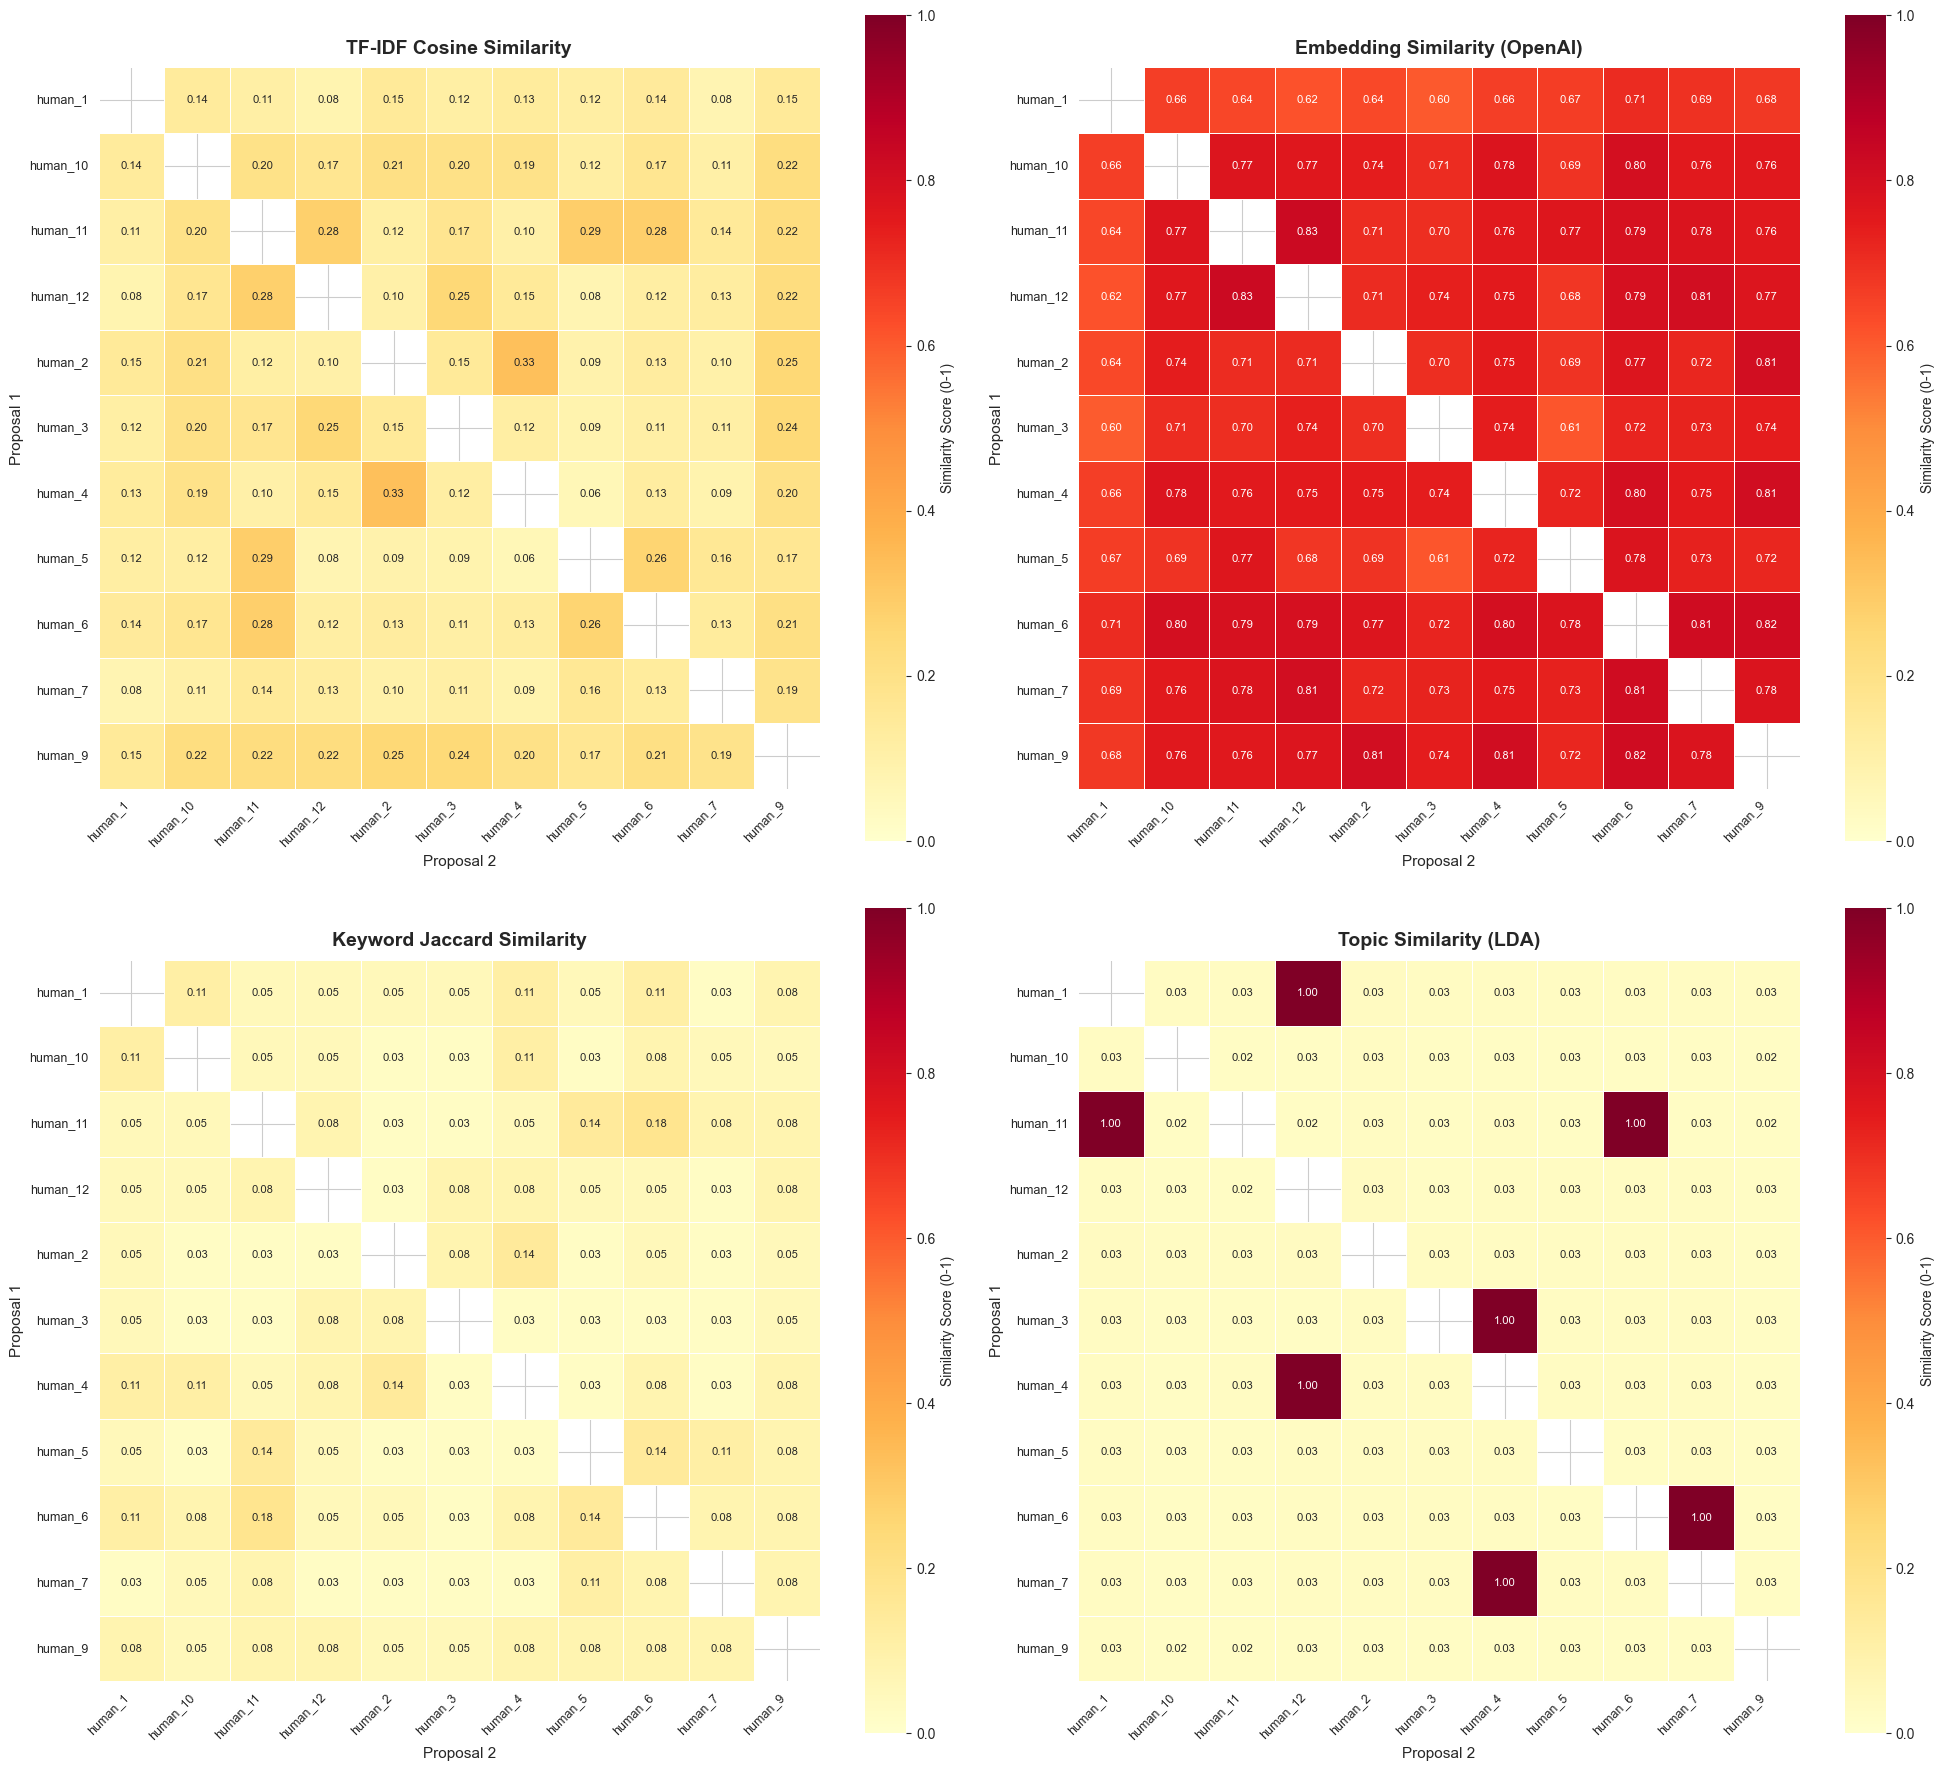

Combined similarity heatmap created!


In [12]:
# Create combined view of all similarity metrics
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten()

# Nice metric names for display
metric_names = {
    'tfidf_similarity': 'TF-IDF Cosine Similarity',
    'embedding_similarity': 'Embedding Similarity (OpenAI)',
    'keyword_jaccard': 'Keyword Jaccard Similarity',
    'topic_similarity': 'Topic Similarity (LDA)'
}

for idx, metric in enumerate(similarity_metrics):
    ax = axes[idx]
    matrix = sim_matrices[metric]
    
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap='YlOrRd', vmin=0, vmax=1,
                cbar_kws={'label': 'Similarity Score (0-1)'}, xticklabels=sim_proposal_ids,
                yticklabels=sim_proposal_ids, ax=ax, linewidths=0.5, square=True,
                annot_kws={'size': 8})
    
    ax.set_title(metric_names[metric], fontsize=14, fontweight='bold', pad=10)
    ax.set_xlabel('Proposal 2', fontsize=11)
    ax.set_ylabel('Proposal 1', fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('similarity_analysis/similarity_matrices_combined.png', dpi=300, bbox_inches='tight')
plt.show()

print("Combined similarity heatmap created!")


In [ ]:
# Create individual detailed heatmaps for each similarity metric
for metric in similarity_metrics:
    fig, ax = plt.subplots(figsize=(14, 12))
    matrix = sim_matrices[metric]
    
    sns.heatmap(matrix, annot=True, fmt='.3f', cmap='YlOrRd', vmin=0, vmax=1,
                cbar_kws={'label': 'Similarity Score (0-1)'}, xticklabels=sim_proposal_ids,
                yticklabels=sim_proposal_ids, ax=ax, linewidths=1, linecolor='white',
                square=True, annot_kws={'size': 10, 'weight': 'bold'})
    
    ax.set_title(f'{metric_names[metric]}\nPairwise Similarity Scores', 
                 fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Proposal 2 (Compared Against)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Proposal 1 (Reference)', fontsize=13, fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
    
    plt.tight_layout()
    safe_name = metric.replace('_', '_')
    plt.savefig(f'similarity_analysis/matrix_{safe_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: matrix_{safe_name}.png")


In [13]:
# Summary statistics for similarity metrics
print("="*70)
print("SIMILARITY METRICS SUMMARY STATISTICS")
print("="*70)

for metric in similarity_metrics:
    matrix = sim_matrices[metric]
    valid_scores = matrix[~np.isnan(matrix)]
    
    print(f"\n{metric_names[metric]}:")
    print(f"  Mean: {np.mean(valid_scores):.4f}")
    print(f"  Median: {np.median(valid_scores):.4f}")
    print(f"  Std dev: {np.std(valid_scores):.4f}")
    print(f"  Min: {np.min(valid_scores):.4f}, Max: {np.max(valid_scores):.4f}")
    print(f"  Range: {np.max(valid_scores) - np.min(valid_scores):.4f}")
    
    # Percentiles
    p25, p50, p75 = np.percentile(valid_scores, [25, 50, 75])
    print(f"  Percentiles: 25th={p25:.4f}, 50th={p50:.4f}, 75th={p75:.4f}")


SIMILARITY METRICS SUMMARY STATISTICS

TF-IDF Cosine Similarity:
  Mean: 0.1594
  Median: 0.1449
  Std dev: 0.0622
  Min: 0.0599, Max: 0.3282
  Range: 0.2683
  Percentiles: 25th=0.1128, 50th=0.1449, 75th=0.2011

Embedding Similarity (OpenAI):
  Mean: 0.7345
  Median: 0.7439
  Std dev: 0.0552
  Min: 0.6015, Max: 0.8263
  Range: 0.2248
  Percentiles: 25th=0.7000, 50th=0.7439, 75th=0.7752

Keyword Jaccard Similarity:
  Mean: 0.0650
  Median: 0.0526
  Std dev: 0.0362
  Min: 0.0256, Max: 0.1765
  Range: 0.1508
  Percentiles: 25th=0.0256, 50th=0.0526, 75th=0.0811

Topic Similarity (LDA):
  Mean: 0.0896
  Median: 0.0279
  Std dev: 0.2373
  Min: 0.0241, Max: 1.0000
  Range: 0.9759
  Percentiles: 25th=0.0262, 50th=0.0279, 75th=0.0297


In [ ]:
# Correlation between different similarity metrics
print("\n" + "="*70)
print("CORRELATION BETWEEN SIMILARITY METRICS")
print("="*70)

# Flatten all matrices and compute correlation
correlation_data = {}
for metric in similarity_metrics:
    matrix = sim_matrices[metric]
    # Flatten and remove NaN
    correlation_data[metric] = matrix.flatten()

# Create correlation dataframe
corr_df = pd.DataFrame(correlation_data)
correlation_matrix = corr_df.corr()

print("\nPearson Correlation Matrix:")
print(correlation_matrix)

# Visualize correlation
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
            vmin=-1, vmax=1, center=0, square=True, linewidths=1,
            xticklabels=[metric_names[m] for m in similarity_metrics],
            yticklabels=[metric_names[m] for m in similarity_metrics],
            cbar_kws={'label': 'Correlation Coefficient'})

ax.set_title('Correlation Between Similarity Metrics', fontsize=14, fontweight='bold', pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('similarity_analysis/metrics_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCorrelation heatmap saved!")


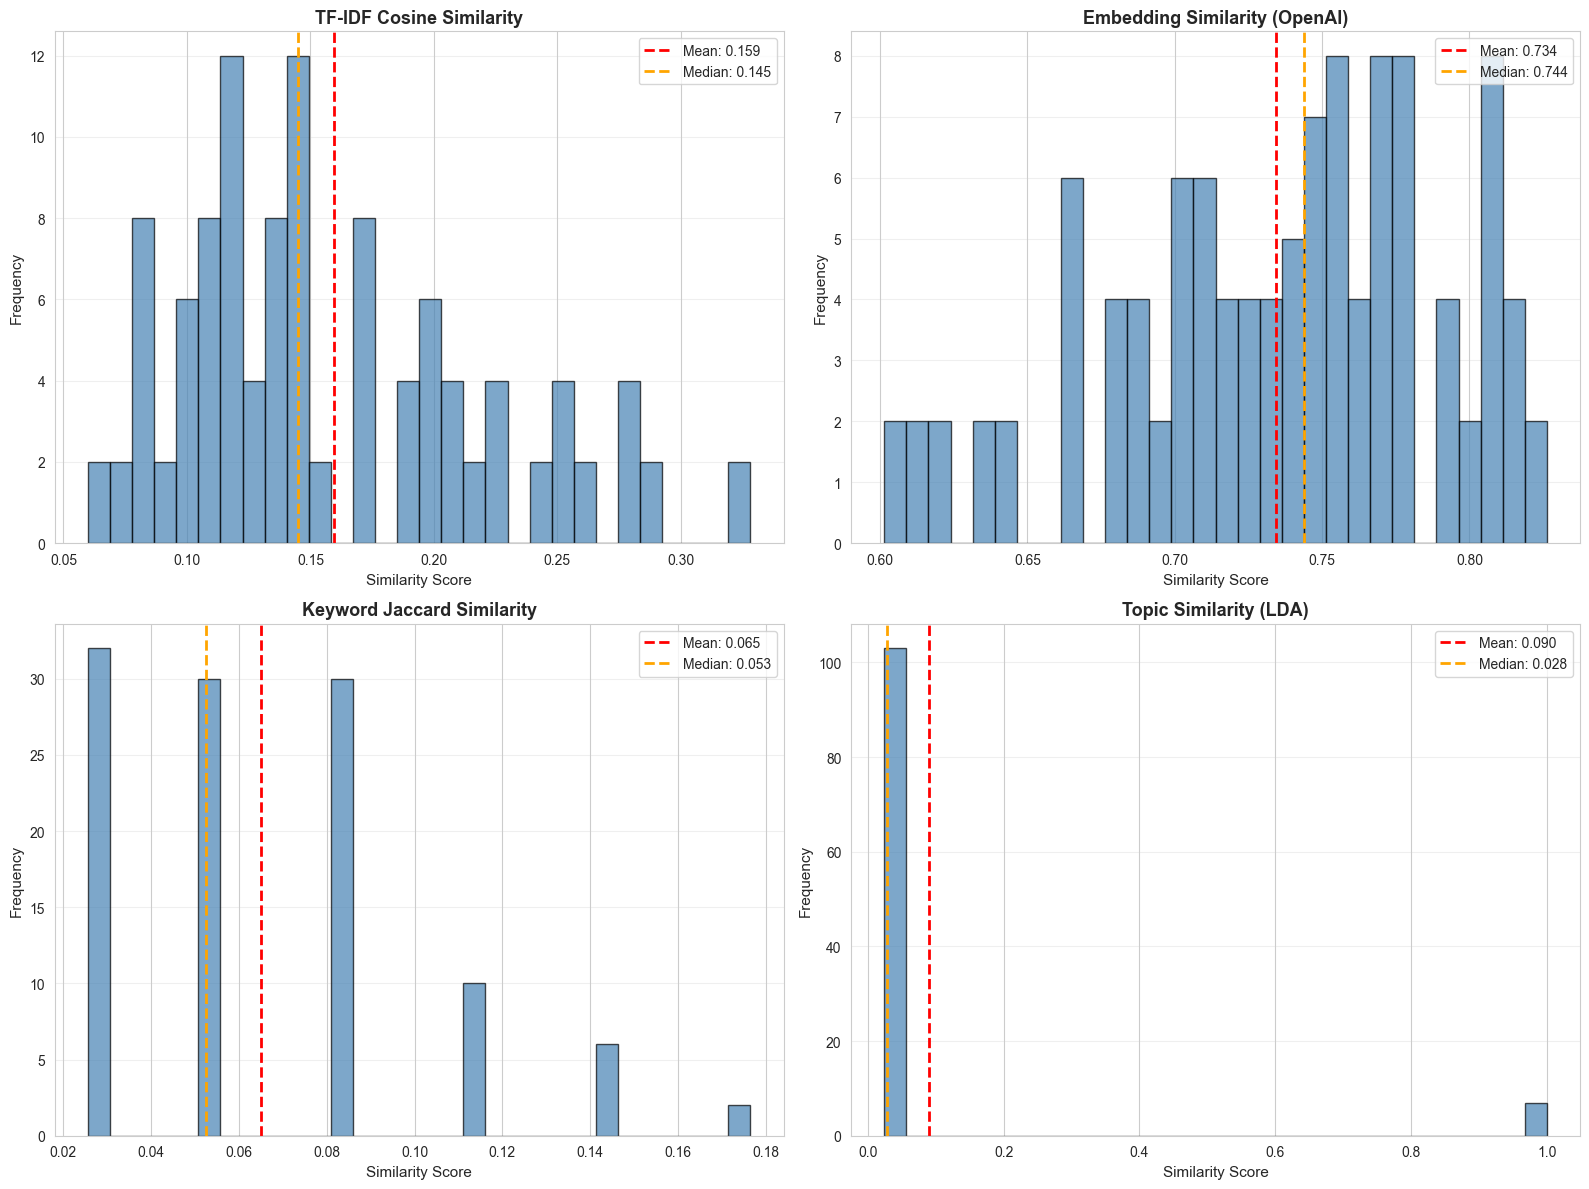

Distribution plots saved!


In [14]:
# Distribution plots for each similarity metric
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, metric in enumerate(similarity_metrics):
    ax = axes[idx]
    matrix = sim_matrices[metric]
    valid_scores = matrix[~np.isnan(matrix)]
    
    # Create histogram
    ax.hist(valid_scores, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax.axvline(np.mean(valid_scores), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(valid_scores):.3f}')
    ax.axvline(np.median(valid_scores), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(valid_scores):.3f}')
    
    ax.set_title(metric_names[metric], fontsize=13, fontweight='bold')
    ax.set_xlabel('Similarity Score', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('similarity_analysis/similarity_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Distribution plots saved!")


In [ ]:
# Find high similarity proposal pairs (top 10% for each metric)
print("\n" + "="*70)
print("HIGH SIMILARITY PAIRS (Top 10% for each metric)")
print("="*70)

for metric in similarity_metrics:
    matrix = sim_matrices[metric]
    valid_scores = matrix[~np.isnan(matrix)]
    threshold = np.percentile(valid_scores, 90)  # Top 10%
    
    high_sim_indices = np.argwhere(matrix >= threshold)
    
    print(f"\n{metric_names[metric]} (threshold >= {threshold:.4f}):")
    
    # Sort by score (descending)
    pairs_with_scores = []
    for idx1, idx2 in high_sim_indices:
        prop1 = sim_proposal_ids[idx1]
        prop2 = sim_proposal_ids[idx2]
        score = matrix[idx1, idx2]
        pairs_with_scores.append((prop1, prop2, score))
    
    pairs_with_scores.sort(key=lambda x: x[2], reverse=True)
    
    for prop1, prop2, score in pairs_with_scores[:10]:  # Show top 10
        print(f"  {prop1} vs {prop2}: {score:.4f}")


In [ ]:
# Load similarity analysis results
similarity_file = "similarity_analysis/similarity_human-human_20251030_160213.csv"
similarity_df = pd.read_csv(similarity_file)

print(f"Loaded {len(similarity_df)} similarity comparisons")
print(f"\nColumns: {list(similarity_df.columns)}")
print(f"\nFirst few rows:")
similarity_df.head()
